In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller  # Import the ADF test function
from statsmodels.tsa.seasonal import seasonal_decompose  # Import seasonal decomposition
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Import ACF and PACF plotting functions
from statsmodels.tsa.arima.model import ARIMA  # Import ARIMA model (ARMA is a special case of ARIMA)
from statsmodels.stats.diagnostic import acorr_ljungbox  # Import Ljung-Box test for autocorrelation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



---
---
---
---
---

# **AMZN DATASET**
---
---
---
---
---




# **Load and Inspect the Data**

We load the dataset (e.g., Amazon stock prices) and perform a quick check on its structure

In [ ]:
# Load the dataset
amzn_data = pd.read_csv('/content/AMZN.csv', parse_dates=True, index_col='Date')

# Check the first few rows of the data
amzn_data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


# **Step: 1. Make Initial Plots of the Data**

Visualizing the time series data allows us to identify trends, seasonality, and any obvious patterns (like upward or downward trends). This step gives us an overview of the dataset.


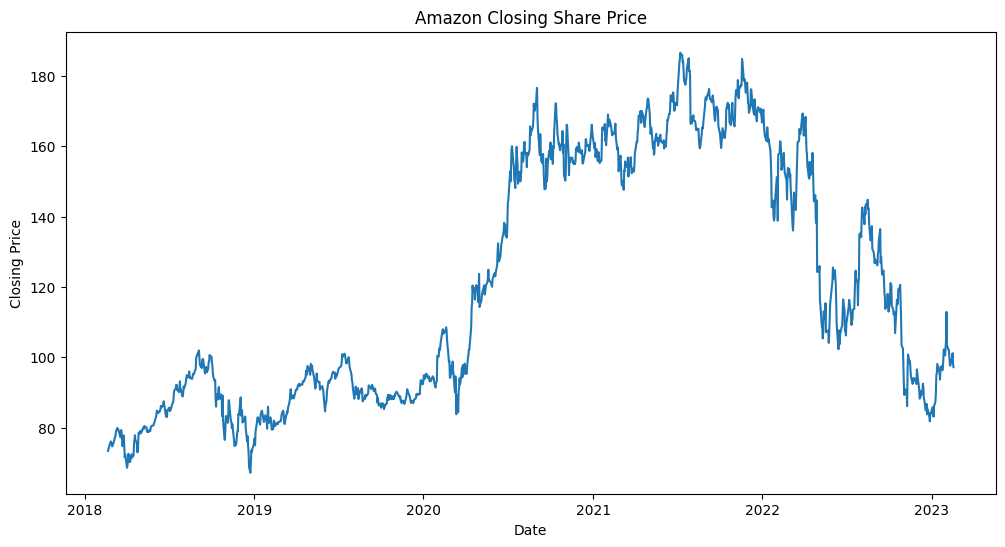

In [ ]:
# Plotting the Amazon closing share price data
plt.figure(figsize=(12, 6))  # Set the figure size for better visibility
plt.plot(amzn_data['Close'])  # Plot the closing price of Amazon shares
plt.title('Amazon Closing Share Price')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis (time)
plt.ylabel('Closing Price')  # Label for the y-axis (price)
plt.show()  # Display the plot


# **Step 2. Perform All the Time Series Analysis Tasks to Test for Non-Stationarity**


## **1. Test for Stationarity using the Augmented Dickey-Fuller (ADF) Test**

The Augmented Dickey-Fuller (ADF) test is used to formally test whether the time series is stationary or has a unit root. If the p-value is greater than 0.05, the series is non-stationary.


In [ ]:
# Function to perform Augmented Dickey-Fuller (ADF) Test
def test_stationarity(series):
    """
    Perform Augmented Dickey-Fuller test to check stationarity.
    """
    result = adfuller(series)  # Perform the ADF test
    print(f"ADF Statistic: {result[0]}")  # The test statistic
    print(f"p-value: {result[1]}")  # The p-value for the test
    print(f"Critical Values: {result[4]}")  # The critical values at various significance levels
    if result[1] < 0.05:
        print("The series is likely stationary (Reject null hypothesis).")
    else:
        print("The series is likely non-stationary (Fail to reject null hypothesis).")

# Applying ADF test to Amazon's closing prices
test_stationarity(amzn_data['Close'])


ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Critical Values: {'1%': np.float64(-3.4355588184378574), '5%': np.float64(-2.8638402312881497), '10%': np.float64(-2.5679946684494275)}
The series is likely non-stationary (Fail to reject null hypothesis).


## **2. Examine Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)**

The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots help determine the presence of lag dependencies in the data. These plots are helpful in model identification.



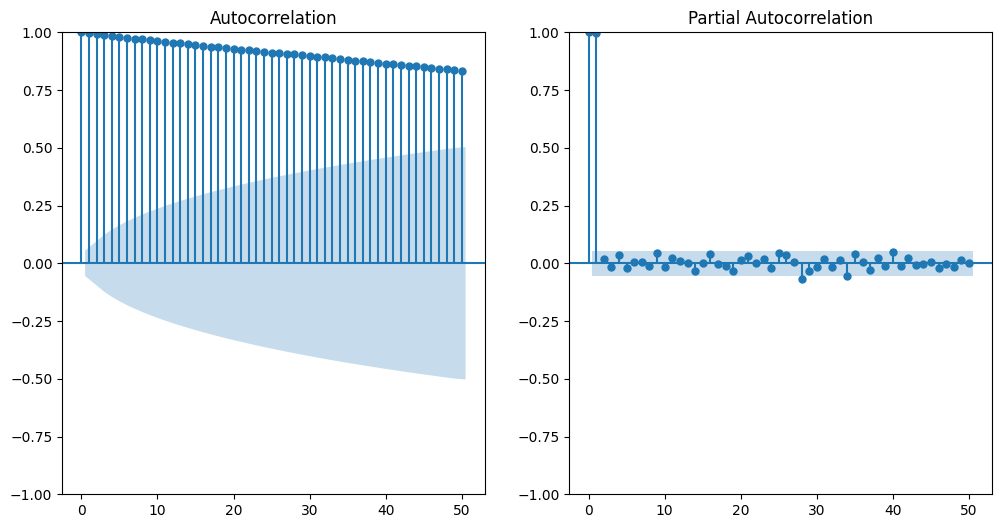

In [ ]:
# Plotting the Autocorrelation and Partial Autocorrelation
plt.figure(figsize=(12, 6))  # Set figure size for clarity
plt.subplot(121)  # First subplot for ACF
plot_acf(amzn_data['Close'], ax=plt.gca(), lags=50)  # ACF plot with 50 lags
plt.subplot(122)  # Second subplot for PACF
plot_pacf(amzn_data['Close'], ax=plt.gca(), lags=50)  # PACF plot with 50 lags
plt.show()  # Display the plots


## **3. Seasonal Decomposition**


Decomposing the time series helps in analyzing the individual components: trend, seasonality, and residuals. This step is useful if we suspect seasonal patterns in the data.


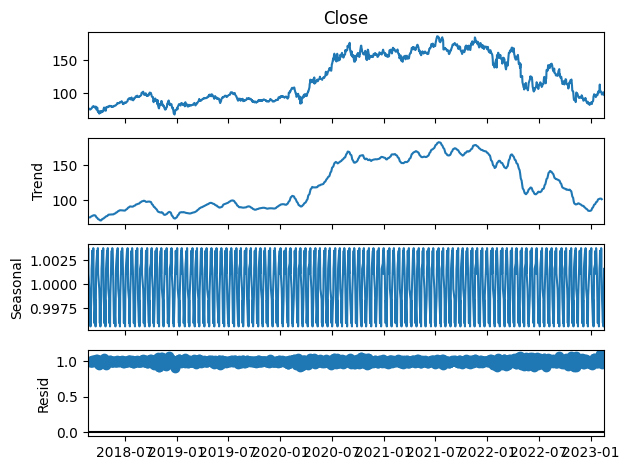

In [ ]:
# Decompose the time series to analyze trend, seasonality, and residuals
decomposition = seasonal_decompose(amzn_data['Close'], model='multiplicative', period=12)  # Period of 12 for monthly data
decomposition.plot()  # Plot the decomposition
plt.show()  # Display the decomposition plots


# **Step 3. Make the Data Stationary**

If the data is found to be non-stationary, differencing is applied to make the data stationary. This involves subtracting the current value from the previous value to remove trends.



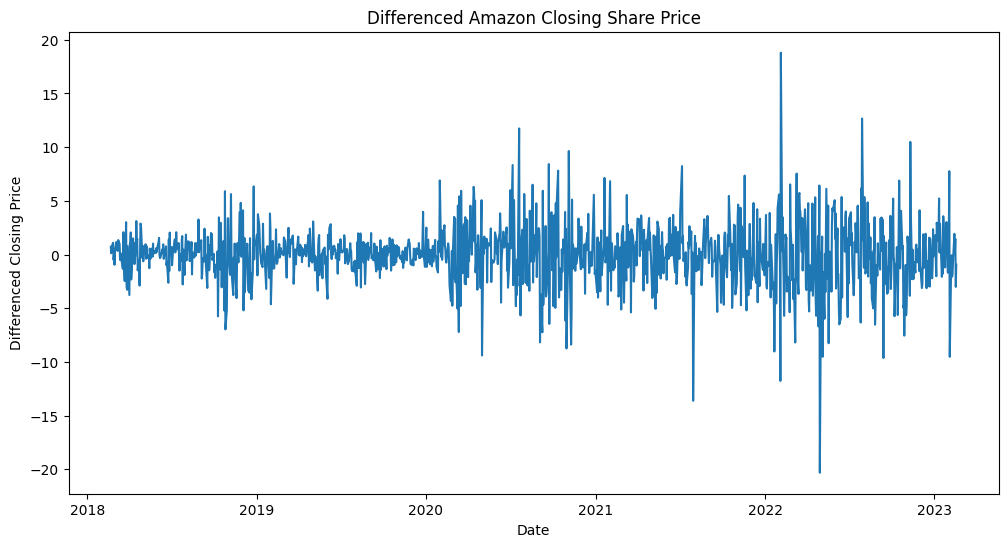

ADF Statistic: -36.25077933242776
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4355629707955395), '5%': np.float64(-2.863842063387667), '10%': np.float64(-2.567995644141416)}
The series is likely stationary (Reject null hypothesis).


In [ ]:
# Differencing the series to remove trend and make it stationary
amzn_data['Close_diff'] = amzn_data['Close'].diff().dropna()  # Difference the data

# Plotting the differenced data
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close_diff'])  # Plot the differenced data
plt.title('Differenced Amazon Closing Share Price')  # Title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Differenced Closing Price')  # Y-axis label
plt.show()  # Display the plot

# Re-test stationarity after differencing
test_stationarity(amzn_data['Close_diff'].dropna())  # Reapply the ADF test to the differenced data


# **Step 5. Find the Best Model Parameters: p, d, q**

Optimize p, d, q by comparing AIC values or using grid search

In [ ]:
# Grid Search for Optimal p, d, q values
best_aic = np.inf
best_order = None

for p in range(1, 6):
    for q in range(1, 6):
        try:
            model = ARIMA(amzn_data['Close'], order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue

print(f"Best ARMA Model Parameters: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARMA Model Parameters: p=2, d=2, q=3


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# **Step 4: Define and Fit an ARMA Model**

This step defines an ARMA (Autoregressive Moving Average) model with selected parameters and fits the model to the data. ARMA is commonly used for stationary time series forecasting.

We define an ARMA model with the selected parameters (p=2, d=2, q=3).



In [ ]:
# Define ARMA model parameters (p, d, q)
p, d, q = 2, 2, 3  # Example ARMA(5, 1, 0) model, you can adjust p, d, q based on earlier analysis
arma_model = ARIMA(amzn_data['Close'], order=(p, d, q))  # Fit the ARMA model
arma_model_fit = arma_model.fit()  # Fit the model to the data

# Print ARMA model summary
print(arma_model_fit.summary())  # Show the model summary


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -3057.762
Date:                Fri, 11 Apr 2025   AIC                           6127.524
Time:                        01:23:00   BIC                           6158.343
Sample:                             0   HQIC                          6139.107
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6945      0.015   -111.996      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.669      0.000      -0.989      -0.931
ma.L1          0.6973      0.043     16.095      0.0

# **Step 6. Test Model Performance**

We need to evaluate the model’s residuals to check if they resemble white noise. If residuals are autocorrelated, the model is not well-specified.



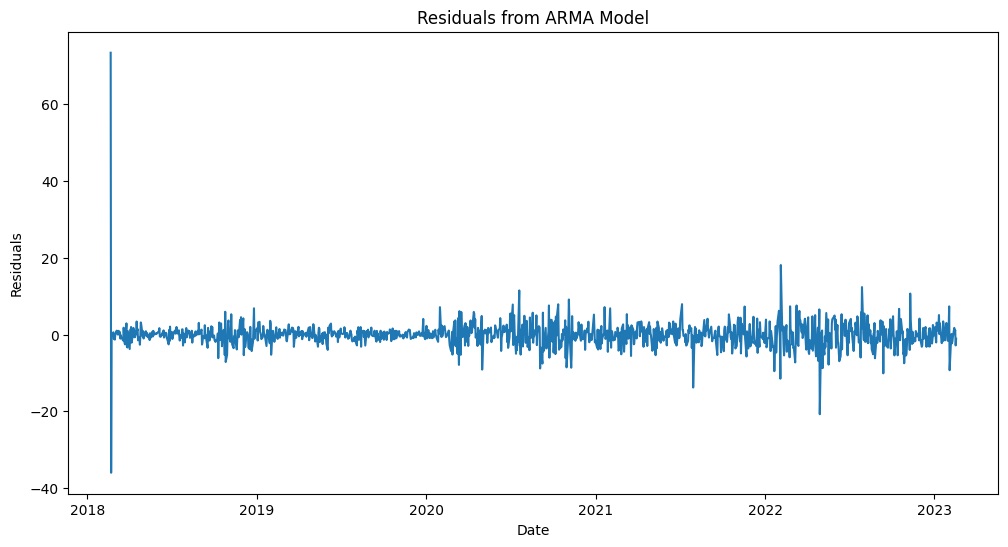

      lb_stat     lb_pvalue
1   36.603910  1.447411e-09
2   36.604052  1.125981e-08
3   36.788338  5.101135e-08
4   36.886617  1.900829e-07
5   36.910134  6.243130e-07
6   36.961480  1.791597e-06
7   36.972152  4.747980e-06
8   37.586413  8.975022e-06
9   37.630904  2.029939e-05
10  37.632251  4.397182e-05


In [ ]:
# Plotting the residuals of the ARMA model
residuals = arma_model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)  # Plot residuals
plt.title('Residuals from ARMA Model')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Residuals')  # Y-axis label
plt.show()

# Perform Ljung-Box test on residuals to check for autocorrelation
ljung_box_result = acorr_ljungbox(residuals, lags=10)  # Ljung-Box test for up to 10 lags
print(ljung_box_result)  # Print the result of the test


# **Step 7. Forecast the Next 24 Months with ARMA**


Using the fitted ARMA model, we forecast future values (24 months ahead in this case).

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-157-ff06f383b798>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]  # Create future date range


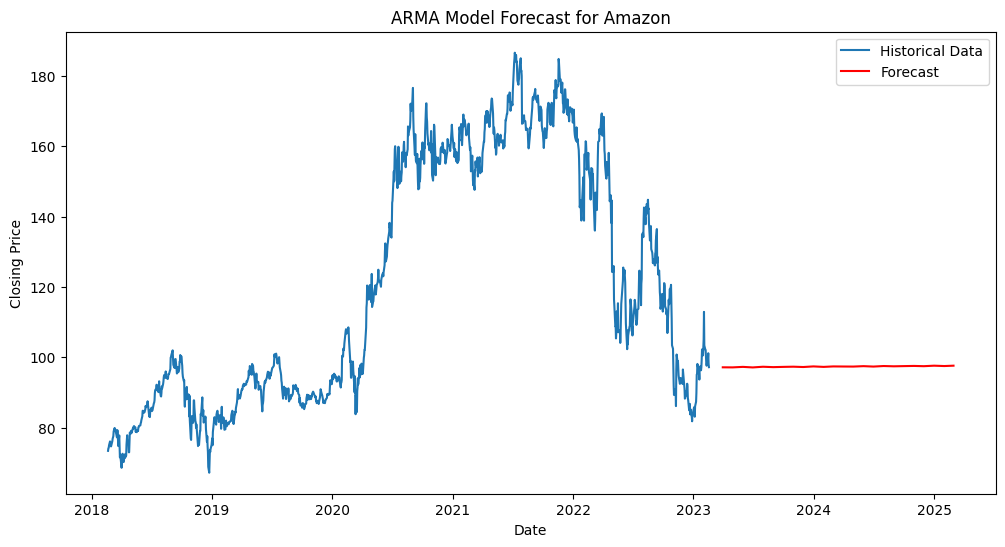

In [ ]:
# Forecast the next 24 months using the ARMA model
forecast_steps = 24  # Define the number of forecast steps
forecast = arma_model_fit.forecast(steps=forecast_steps)  # Perform the forecast
forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]  # Create future date range

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close'], label='Historical Data')  # Historical data
plt.plot(forecast_index, forecast, label='Forecast', color='red')  # Forecasted data in red
plt.title('ARMA Model Forecast for Amazon')  # Title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Closing Price')  # Y-axis label
plt.legend()  # Add legend
plt.show()  # Display the plot


# **Step 8. Build an RNN-Based Model (LSTM)**

We now use LSTM (Long Short-Term Memory) for forecasting. This models are well-suited for time series data.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 0.0121
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


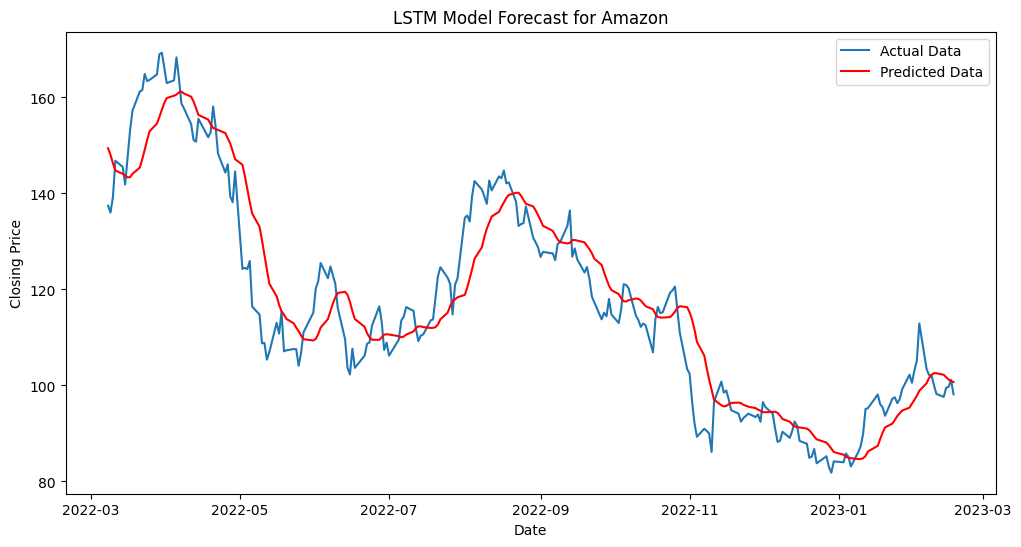

In [ ]:
# Normalize the data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
amzn_scaled = scaler.fit_transform(amzn_data['Close'].values.reshape(-1, 1))

# Prepare dataset for LSTM/GRU
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Time step for LSTM
X, Y = create_dataset(amzn_scaled, time_step)

# Reshape X to be compatible with LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Predict using LSTM model
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform([Y_test])

# Plot LSTM predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(amzn_data.index[-len(Y_test_rescaled[0]):], Y_test_rescaled[0], label='Actual Data')
plt.plot(amzn_data.index[-len(predictions):], predictions, label='Predicted Data', color='red')
plt.title('LSTM Model Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# **Step 9. Forecast 24 Months with LSTM**

We forecast the next 24 months using the trained LSTM model.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


<ipython-input-160-b08218bfb9bd>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]


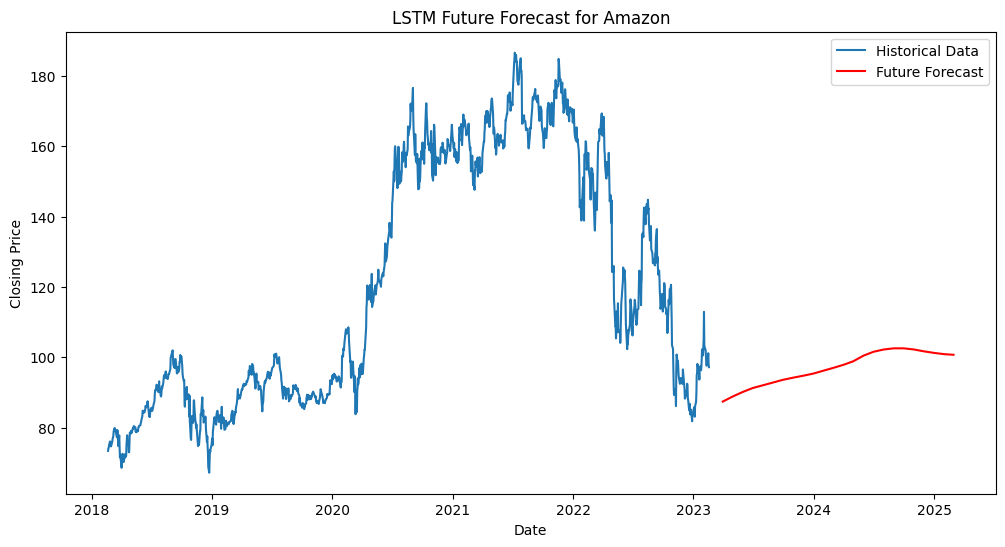

In [ ]:
# Predict 24 months ahead using LSTM
forecast_steps = 24
future_predictions = model.predict(X_test[-forecast_steps:])

# Inverse scale the forecast
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Plot the forecast
forecast_index = pd.date_range(start=amzn_data.index[-1], periods=forecast_steps+1, freq='M')[1:]

plt.figure(figsize=(12, 6))
plt.plot(amzn_data['Close'], label='Historical Data')
plt.plot(forecast_index, future_predictions_rescaled, label='Future Forecast', color='red')
plt.title('LSTM Future Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# **Step 10: Compute Evaluation Metrics**


In [ ]:
# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(Y_test_rescaled[0], predictions)
print(f'Mean Squared Error (MSE) of the LSTM model: {mse}')

# Compute the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) of the LSTM model: {rmse}')

# Compute the Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test_rescaled[0], predictions)
print(f'Mean Absolute Error (MAE) of the LSTM model: {mae}')

# Compute R-squared (R²)
r2 = r2_score(Y_test_rescaled[0], predictions)
print(f'R-squared (R²) of the LSTM model: {r2}')

# Compute the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test_rescaled[0] - predictions) / Y_test_rescaled[0])) * 100
print(f'Mean Absolute Percentage Error (MAPE) of the LSTM model: {mape}%')

# Compute the Symmetric Mean Absolute Percentage Error (sMAPE)
smape = np.mean(2 * np.abs(predictions - Y_test_rescaled[0]) / (np.abs(Y_test_rescaled[0]) + np.abs(predictions))) * 100
print(f'Symmetric Mean Absolute Percentage Error (sMAPE) of the LSTM model: {smape}%')

Mean Squared Error (MSE) of the LSTM model: 61.21901732533538
Root Mean Squared Error (RMSE) of the LSTM model: 7.824258260393465
Mean Absolute Error (MAE) of the LSTM model: 6.141071956591797
R-squared (R²) of the LSTM model: 0.8728351887159063
Mean Absolute Percentage Error (MAPE) of the LSTM model: 21.210858224794755%
Symmetric Mean Absolute Percentage Error (sMAPE) of the LSTM model: 20.44908440705557%


# **Step 11: Actual vs. Predicted Values (ARMA vs. LSTM)**

# **Plot Actual vs. Predicted Values (ARMA vs. LSTM)**

This plot shows how well both models (ARMA and LSTM) fit the data by comparing their predictions to the actual values.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


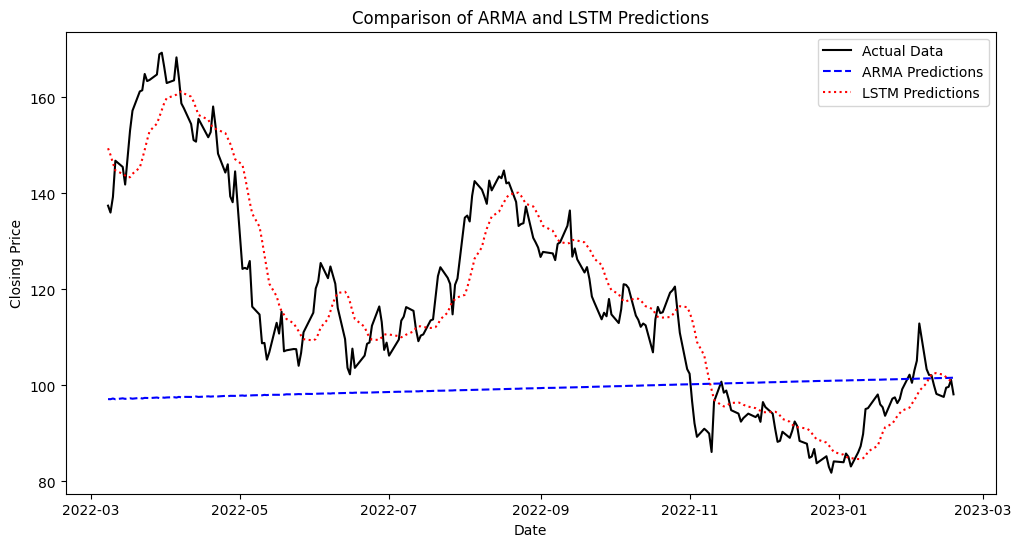

In [ ]:
# ARMA model predictions (we assume `arma_model_fit` is already fitted)
arma_predictions = arma_model_fit.forecast(steps=len(Y_test_rescaled[0]))  # Forecast for test set

# LSTM model predictions (already computed)
lstm_predictions = predictions  # Predicted values from LSTM model (inverse scaled)

# Plot the actual values, ARMA predictions, and LSTM predictions
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(amzn_data.index[-len(Y_test_rescaled[0]):], Y_test_rescaled[0], label='Actual Data', color='black')

# Plot ARMA model predictions
plt.plot(amzn_data.index[-len(arma_predictions):], arma_predictions, label='ARMA Predictions', color='blue', linestyle='--')

# Plot LSTM model predictions
plt.plot(amzn_data.index[-len(lstm_predictions):], lstm_predictions, label='LSTM Predictions', color='red', linestyle=':')

plt.title('Comparison of ARMA and LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


# **Plot Residuals (Differences Between Actual and Predicted Values)**

Residuals are the differences between the actual values and the predicted values. Plotting the residuals for both models can help identify which model fits the data better. Ideally, the residuals should resemble white noise (i.e., no discernible pattern).



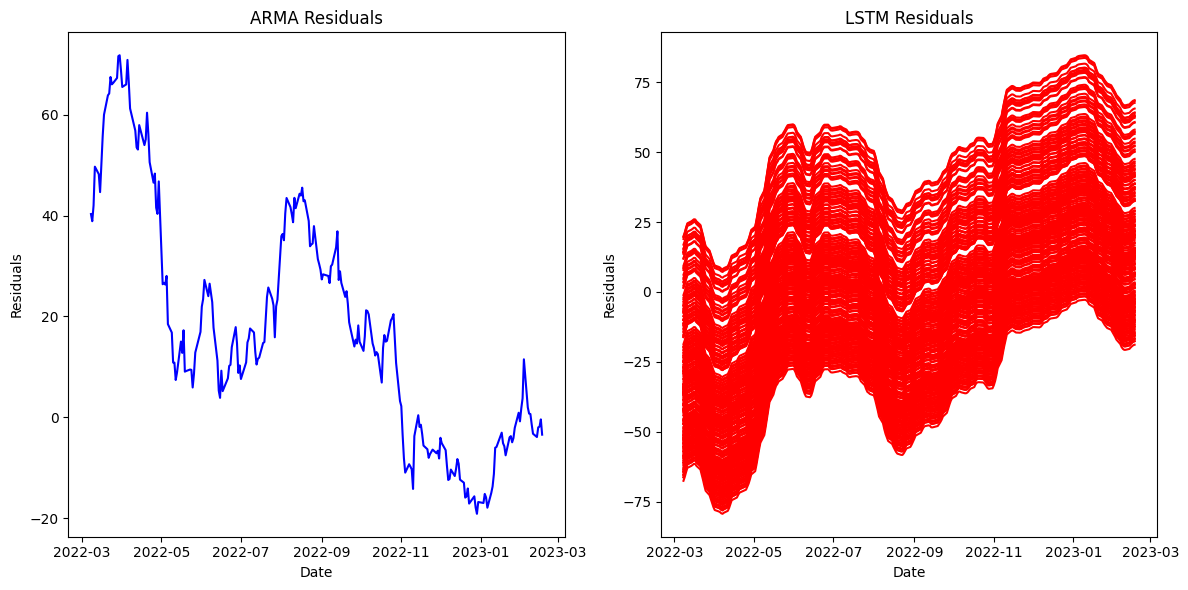

In [ ]:
# ARMA residuals
arma_residuals = Y_test_rescaled[0] - arma_predictions

# LSTM residuals
lstm_residuals = Y_test_rescaled[0] - lstm_predictions

# Plot the residuals for ARMA and LSTM
plt.figure(figsize=(12, 6))

# Plot ARMA residuals
plt.subplot(121)
plt.plot(amzn_data.index[-len(arma_residuals):], arma_residuals, label='ARMA Residuals', color='blue')
plt.title('ARMA Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plot LSTM residuals
plt.subplot(122)
plt.plot(amzn_data.index[-len(lstm_residuals):], lstm_residuals, label='LSTM Residuals', color='red')
plt.title('LSTM Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


# **Plot the Forecast Horizons of Both Models**

Compare the forecast horizons (the next 24 months) of both models to see how they perform in the future.



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-164-a961e8519558>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=amzn_data.index[-1], periods=25, freq='M')[1:]


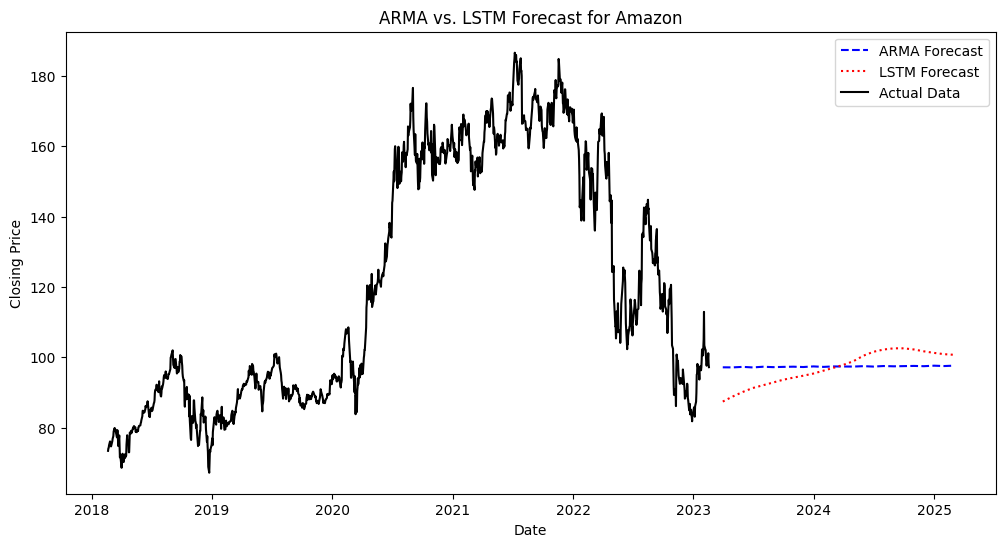

In [ ]:
# ARMA forecast for the next 24 months (already computed)
arma_forecast = arma_model_fit.forecast(steps=24)

# LSTM forecast for the next 24 months
lstm_forecast = future_predictions_rescaled  # The LSTM forecast for the next 24 months (inverse scaled)

# Generate future time index
forecast_index = pd.date_range(start=amzn_data.index[-1], periods=25, freq='M')[1:]

# Plot the forecasts of both models
plt.figure(figsize=(12, 6))

# Plot ARMA forecast
plt.plot(forecast_index, arma_forecast, label='ARMA Forecast', color='blue', linestyle='--')

# Plot LSTM forecast
plt.plot(forecast_index, lstm_forecast, label='LSTM Forecast', color='red', linestyle=':')

# Plot the actual historical data for context
plt.plot(amzn_data.index, amzn_data['Close'], label='Actual Data', color='black')

plt.title('ARMA vs. LSTM Forecast for Amazon')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


## **Compare Metrics for Both**

Now, we can compute and compare the evaluation metrics (such as MSE, MAE, RMSE, R², etc.) for both models and see which one performs better.

In [ ]:
# Compute the Mean Squared Error (MSE) for both models
arma_mse = mean_squared_error(Y_test_rescaled[0], arma_predictions)
lstm_mse = mean_squared_error(Y_test_rescaled[0], lstm_predictions)

# Compute the Mean Absolute Error (MAE) for both models
arma_mae = mean_absolute_error(Y_test_rescaled[0], arma_predictions)
lstm_mae = mean_absolute_error(Y_test_rescaled[0], lstm_predictions)

# Compute the Root Mean Squared Error (RMSE) for both models
arma_rmse = np.sqrt(arma_mse)
lstm_rmse = np.sqrt(lstm_mse)

# Compute R-squared (R²) for both models
arma_r2 = r2_score(Y_test_rescaled[0], arma_predictions)
lstm_r2 = r2_score(Y_test_rescaled[0], lstm_predictions)

# Print the evaluation metrics for both models
print(f"ARMA Model Evaluation Metrics:")
print(f"MSE: {arma_mse}, MAE: {arma_mae}, RMSE: {arma_rmse}, R²: {arma_r2}")
print("\n")
print(f"LSTM Model Evaluation Metrics:")
print(f"MSE: {lstm_mse}, MAE: {lstm_mae}, RMSE: {lstm_rmse}, R²: {lstm_r2}")


ARMA Model Evaluation Metrics:
MSE: 843.2848525515479, MAE: 22.528424190700274, RMSE: 29.039367289105112, R²: -0.7516805041735446


LSTM Model Evaluation Metrics:
MSE: 61.21901732533538, MAE: 6.141071956591797, RMSE: 7.824258260393465, R²: 0.8728351887159063


---
---
---
---
---

# **Johnson & Johnson (jj.csv) dataset**
---
---
---
---
---




We begin by importing the necessary libraries to handle the data, perform time series analysis, and fit models.


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **Load and Inspect the Data**
We load the dataset (Johnson & Johnson sales data) and inspect its structure


In [ ]:

# Load the dataset
data = pd.read_csv('/content/jj.csv', parse_dates=['date'], dayfirst=True)

# Display the first few rows to check the data
data.head()

# Rename columns to be more descriptive
data.rename(columns={'date': 'date', 'data': 'sales_value'}, inplace=True)

# Display the updated dataset
data.head()



,date,sales_value
0,1960-01-01,0.71
1,1960-01-04,0.63
2,1960-02-07,0.85
3,1960-01-10,0.44
4,1961-01-01,0.61


# **Step 1: Plot the initial data to understand its structure**


We plot the sales data over time to visualize its trend and seasonality.


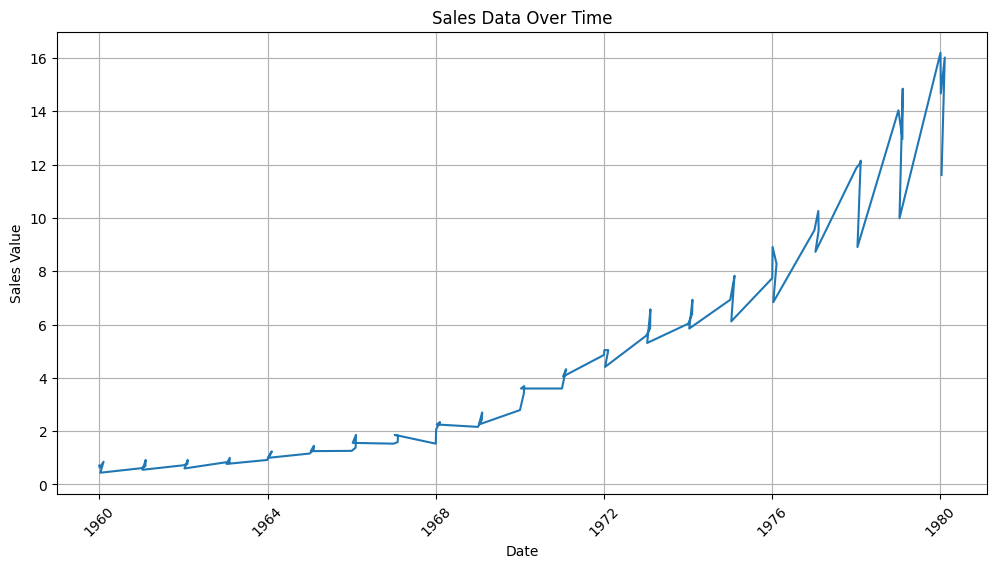

In [ ]:
import matplotlib.pyplot as plt

# Plotting the sales data over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['sales_value'])
plt.title('Sales Data Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# **Step 2: Stationarity Test**

# **Stationarity Test (ADF Test)**

We perform the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.




In [ ]:


# Function to perform the Augmented Dickey-Fuller (ADF) Test
def test_stationarity(series):
    """
    Perform Augmented Dickey-Fuller test to check if the series is stationary.
    """
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")  # ADF test statistic
    print(f"p-value: {result[1]}")  # p-value of the test
    print(f"Critical Values: {result[4]}")  # Critical values for various confidence levels
    if result[1] < 0.05:
        print("The series is likely stationary (Reject null hypothesis).")
    else:
        print("The series is likely non-stationary (Fail to reject null hypothesis).")

# Perform the ADF test on the sales_value data
test_stationarity(data['sales_value'])


ADF Statistic: 2.7420165734574744
p-value: 1.0
Critical Values: {'1%': np.float64(-3.524624466842421), '5%': np.float64(-2.9026070739026064), '10%': np.float64(-2.5886785262345677)}
The series is likely non-stationary (Fail to reject null hypothesis).


## **ACF and PACF Plots**

ACF and PACF plots help us analyze autocorrelations and decide the model (ARMA).

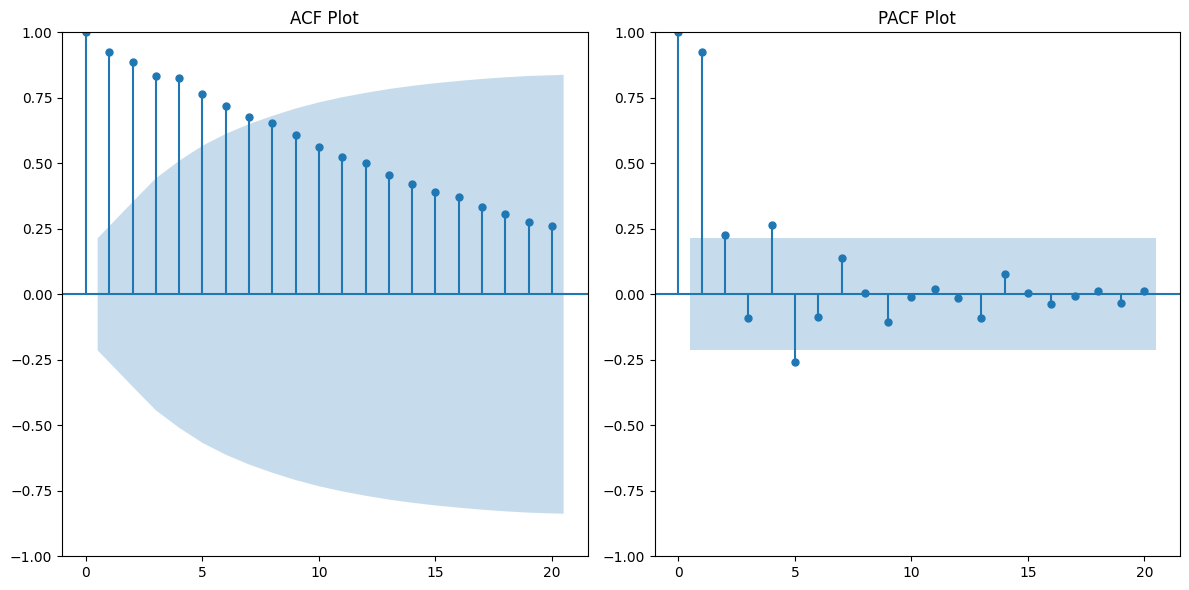

In [ ]:

# Plotting the ACF and PACF for the 'sales_value' data
plt.figure(figsize=(12, 6))

# ACF plot (lags = 20, you can adjust the number of lags based on your data)
plt.subplot(121)
plot_acf(data['sales_value'], ax=plt.gca(), lags=20)
plt.title('ACF Plot')

# PACF plot (lags = 20, you can adjust the number of lags based on your data)
plt.subplot(122)
plot_pacf(data['sales_value'], ax=plt.gca(), lags=20)
plt.title('PACF Plot')

plt.tight_layout()  # Adjust spacing for readability
plt.show()


## **Making the Data Stationary (if needed)**

If the data is non-stationary (i.e., the p-value of the ADF test is greater than 0.05), we apply differencing to make it stationary.

As the series is non-stationary, we apply differencing to remove the trend.


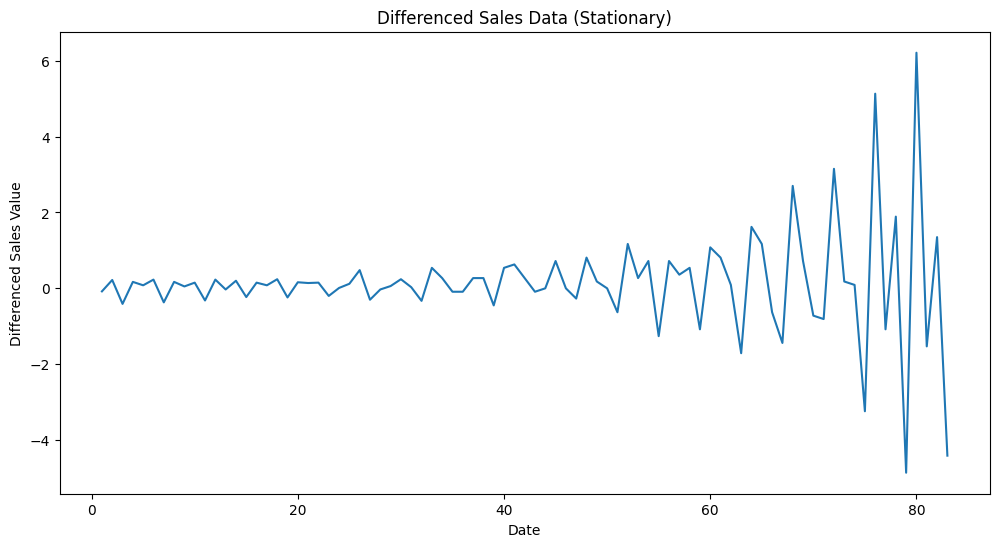

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305
Critical Values: {'1%': np.float64(-3.524624466842421), '5%': np.float64(-2.9026070739026064), '10%': np.float64(-2.5886785262345677)}
The series is likely non-stationary (Fail to reject null hypothesis).
ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682
Critical Values: {'1%': np.float64(-3.524624466842421), '5%': np.float64(-2.9026070739026064), '10%': np.float64(-2.5886785262345677)}
The series is likely stationary (Reject null hypothesis).


In [ ]:
# Differencing the series to make it stationary
data['sales_value_diff'] = data['sales_value'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['sales_value_diff'])
plt.title('Differenced Sales Data (Stationary)')
plt.xlabel('Date')
plt.ylabel('Differenced Sales Value')
plt.show()

# Re-run the ADF test on the differenced series
test_stationarity(data['sales_value_diff'].dropna())
data['sales_value_diff2'] = data['sales_value_diff'].diff().dropna()
test_stationarity(data['sales_value_diff2'].dropna())



## **PDQ**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Assume data['sales_value_diff'].dropna() is the stationary version
best_aic = np.inf
best_order = None


# Grid search over p and q (both from 1 to 5)
for p in range(1, 6):
    for q in range(1, 6):
        try:
            model = ARIMA(data['sales_value'], order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue

print(f"Best ARMA/ARIMA Model Parameters for JJ dataset: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}")



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/s

Best ARMA/ARIMA Model Parameters for JJ dataset: p=5, d=1, q=3


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# **Step 2: Define and Fit an ARMA Model**

Now that the data is stationary, we can define and fit an ARMA model. We will follow a similar procedure as before.

We define and fit the ARMA model (ARIMA with p=2, d=1, q=2).



In [ ]:

# Fit the ARMA model (ARIMA model with d=0 for stationary data)
p, d, q = 5, 1, 3  # ARMA(2, 2) model (adjust parameters as needed based on ACF/PACF)
arma_model = ARIMA(data['sales_value'], order=(p, d, q))  # ARIMA for ARMA model
arma_model_fit = arma_model.fit()

# Print the ARMA model summary
print(arma_model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            sales_value   No. Observations:                   84
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 -49.268
Date:                Fri, 11 Apr 2025   AIC                            116.536
Time:                        00:54:20   BIC                            138.306
Sample:                             0   HQIC                           125.282
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7960      0.324     -2.453      0.014      -1.432      -0.160
ar.L2         -0.0304      0.054     -0.560      0.576      -0.137       0.076
ar.L3          0.0446      0.048      0.924      0.3

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# **Step 4: Evaluate the ARMA Model**


We evaluate the residuals of the ARMA model using the Ljung-Box test and plot them.


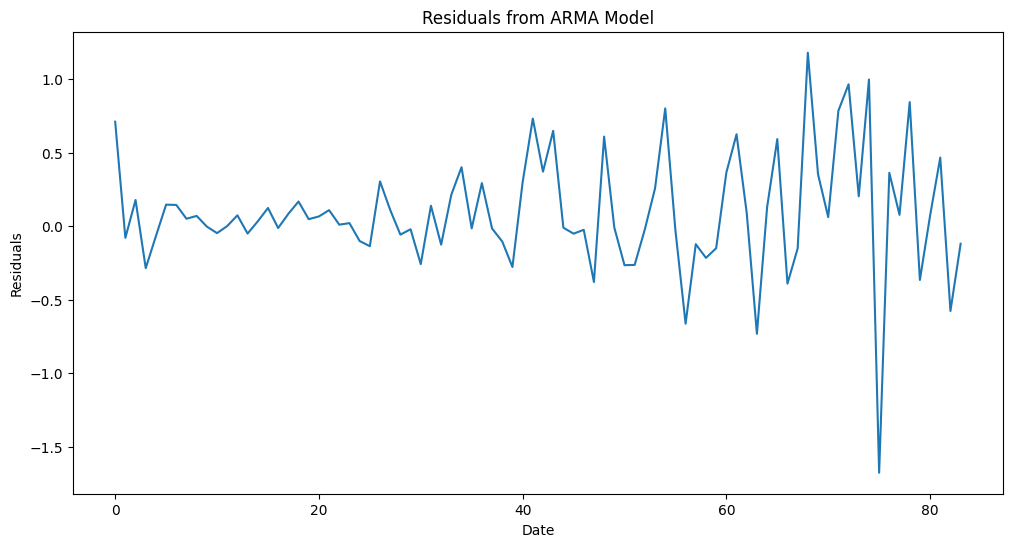

     lb_stat  lb_pvalue
1   0.521468   0.470216
2   0.976152   0.613806
3   1.737971   0.628525
4   1.751889   0.781272
5   2.356026   0.798004
6   2.452243   0.873774
7   4.407555   0.731819
8   4.413649   0.818009
9   4.524606   0.873628
10  5.085874   0.885368


In [ ]:
# Plot the residuals of the ARMA model
residuals = arma_model_fit.resid  # Residuals are the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from ARMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Perform Ljung-Box test on residuals to check for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(residuals, lags=10)
print(ljung_box_result)


# **Step 5: Forecast the Next 24 Months**

We forecast the next 24 months using the trained ARMA model.



<ipython-input-110-d90ae9c140ea>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=data['date'].iloc[-1], periods=forecast_steps+1, freq='M')[1:]  # Generate future dates


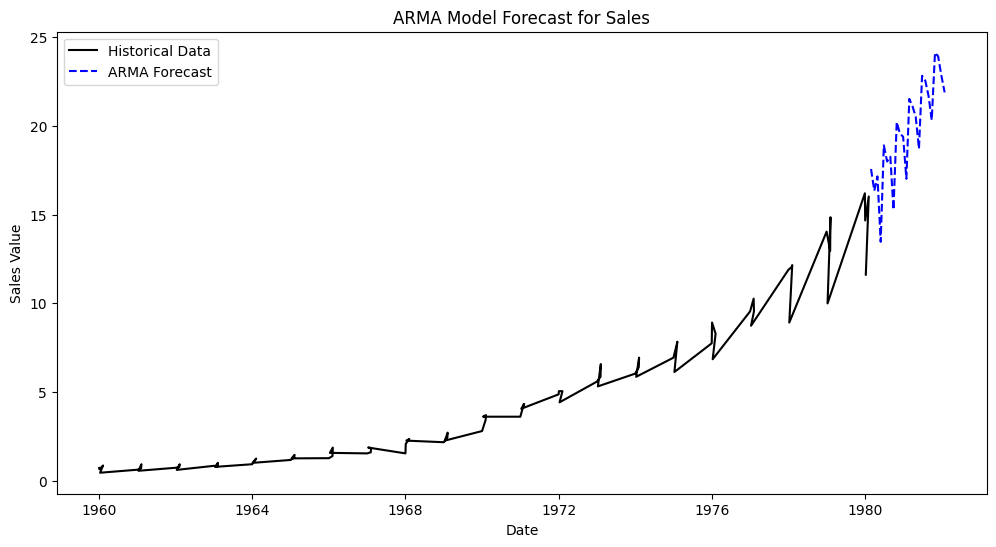

In [ ]:
# Forecast the next 24 months
forecast_steps = 24  # Forecasting the next 24 time points (months)
forecast = arma_model_fit.forecast(steps=forecast_steps)  # Perform the forecast
forecast_index = pd.date_range(start=data['date'].iloc[-1], periods=forecast_steps+1, freq='M')[1:]  # Generate future dates

# Plot the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['sales_value'], label='Historical Data', color='black')  # Plot the historical sales data
plt.plot(forecast_index, forecast, label='ARMA Forecast', color='blue', linestyle='--')  # Plot the ARMA forecast
plt.title('ARMA Model Forecast for Sales')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.show()


# **Step 6: Evaluate the Model's Performance**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define actual and predicted values
actual = data['sales_value'][-len(forecast):].values
predicted = forecast

# Compute the basic metrics
arma_mse = mean_squared_error(actual, predicted)
arma_rmse = np.sqrt(arma_mse)
arma_mae = mean_absolute_error(actual, predicted)
arma_r2 = r2_score(actual, predicted)

# Fix for divide-by-zero errors in MAPE and sMAPE
epsilon = 1e-10  # small constant to avoid division by zero

# Compute MAPE and sMAPE safely
arma_mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100
arma_smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + epsilon)) * 100

# Print results
print("ARMA Model Evaluation Metrics:")
print(f"MSE: {arma_mse:.4f}")
print(f"RMSE: {arma_rmse:.4f}")
print(f"MAE: {arma_mae:.4f}")
print(f"R²: {arma_r2:.4f}")
print(f"MAPE: {arma_mape:.2f}%")
print(f"sMAPE: {arma_smape:.2f}%")


ARMA Model Evaluation Metrics:
MSE: 84.8723
RMSE: 9.2126
MAE: 9.1416
R²: -8.7470
MAPE: 94.13%
sMAPE: 62.62%


# **Step 7: GRU Model for Time Series Forecasting**

## **1: Data Preparation for GRU Model**

Before we can train a GRU model, we need to prepare the data, which includes:

Normalization: GRU models require the data to be scaled.

Creating Sequences: GRUs work with sequential data, so we need to prepare time-based features.

In [ ]:
# 📊 Scale the JJ sales data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['sales_value'].values.reshape(-1, 1))

# Create sequences of past 'time_step' values
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

#  Set lookback window and create input/output
time_step = 60
X, Y = create_dataset(data_scaled, time_step)

#  Reshape for GRU input format: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)


#  Split into training and testing sets (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


## **2: Build the GRU Model**
Next, we build and compile the GRU model using the Keras library. The GRU model consists of two GRU layers followed by a Dense layer for output.

In [ ]:
# 🧱 Build improved GRU model
gru_model = Sequential()
gru_model.add(GRU(units=100, return_sequences=True, input_shape=(time_step, 1)))
gru_model.add(Dropout(0.2))  # regularization
gru_model.add(GRU(units=100, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=25, activation='relu'))
gru_model.add(Dense(units=1))  # output layer

# 🧠 Compile and train
gru_model.compile(optimizer='adam', loss='mean_squared_error')
history = gru_model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_test, Y_test), verbose=1)


# 📈 Predict and inverse transform to original scale
predictions_scaled = gru_model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)
Y_test_rescaled = scaler.inverse_transform(Y_test)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.3842 - val_loss: 0.6075
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 0.3043 - val_loss: 0.4389
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - loss: 0.2194 - val_loss: 0.2801
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1382 - val_loss: 0.1473
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.0781 - val_loss: 0.0564
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0199 - val_loss: 0.0265
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0097 - val_loss: 0.0611
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0432 - val_loss: 0.1000
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0563 - val_loss: 0.1027
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0469 - val_loss: 0.0811
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.0450 - val_loss: 0.0530
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0295 - val_loss: 0.0341
Epo

## **3: Evaluate the GRU Model**
After training the GRU model, we will evaluate its performance on the test data by making predictions and computing key metrics such as MSE, RMSE, MAPE, sMAPE, and MAE.

These metrics will provide more insight into the model's performance and help in evaluating its predictive accuracy.

In [ ]:
# 📊 Evaluate model performance
mse = mean_squared_error(Y_test_rescaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_rescaled, predictions)
r2 = r2_score(Y_test_rescaled, predictions)

epsilon = 1e-10
mape = np.mean(np.abs((Y_test_rescaled - predictions) / (Y_test_rescaled + epsilon))) * 100
smape = np.mean(2 * np.abs(Y_test_rescaled - predictions) / (np.abs(Y_test_rescaled) + np.abs(predictions) + epsilon)) * 100

print("Improved GRU Model Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")


Improved GRU Model Evaluation Metrics:
MSE: 7.2956
RMSE: 2.7010
MAE: 2.3603
R²: -0.1880
MAPE: 19.37%
sMAPE: 17.62%


## **4: Visualize GRU Model Predictions**
Now, we visualize the GRU model predictions along with the actual sales values to assess how well the model fits the data.

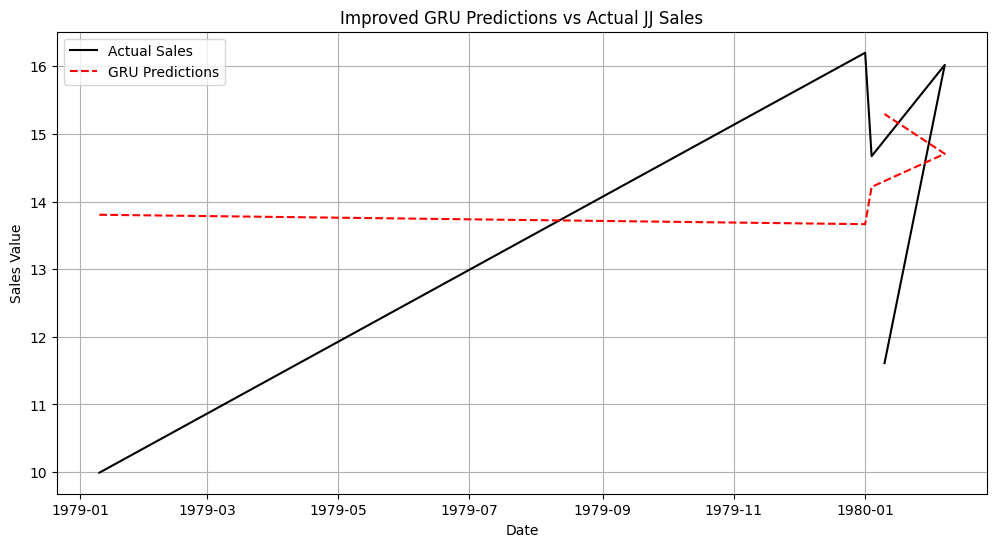

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['date'][-len(predictions):], scaler.inverse_transform(data_scaled)[-len(predictions):], label='Actual Sales', color='black')
plt.plot(data['date'][-len(predictions):], predictions, label='GRU Predictions', color='red', linestyle='--')
plt.title('GRU Predictions vs Actual JJ Sales')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.show()


# **Forecast Next 24 Months Using GRU**


In [ ]:
# Forecast next 24 months using the trained GRU model
forecast_steps = 24
last_sequence = data_scaled[-time_step:].reshape(1, time_step, 1)
future_predictions_scaled = []

for _ in range(forecast_steps):
    next_pred = gru_model.predict(last_sequence)[0][0]
    future_predictions_scaled.append(next_pred)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse transform predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


# **Create Dates & Plot Forecast**

<ipython-input-126-54297e63b806>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


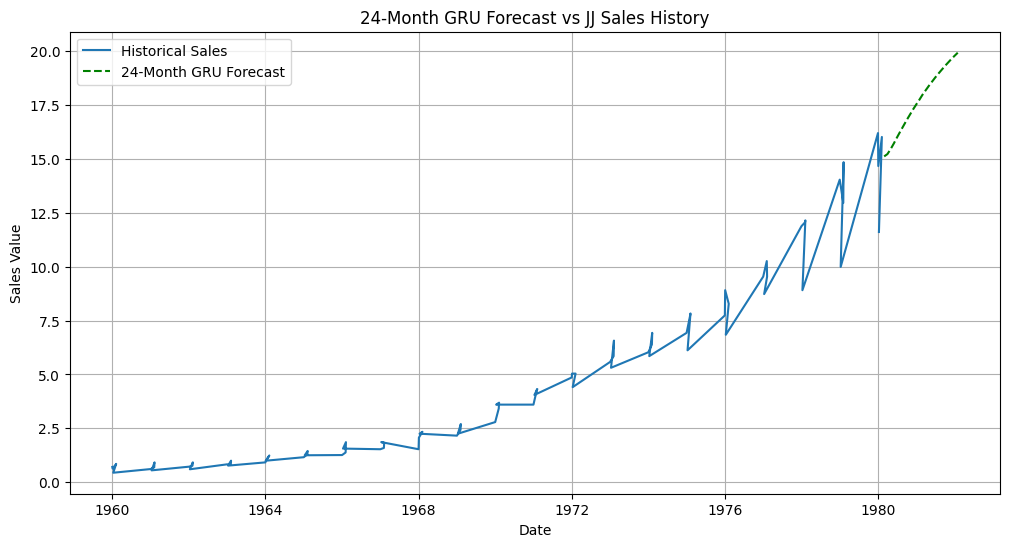

In [ ]:
# 📅 Generate future dates
last_date = data['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# 📈 Plot historical and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['sales_value'], label='Historical Sales')
plt.plot(future_dates, future_predictions, label='24-Month GRU Forecast', color='green', linestyle='--')
plt.title('24-Month GRU Forecast vs JJ Sales History')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.show()


## **Step 7: Compare GRU with ARMA and Other Models**

Compare the GRU model predictions with other models (e.g., ARMA) by plotting all predictions on the same graph. This allows for a clear comparison of how well each model performs.

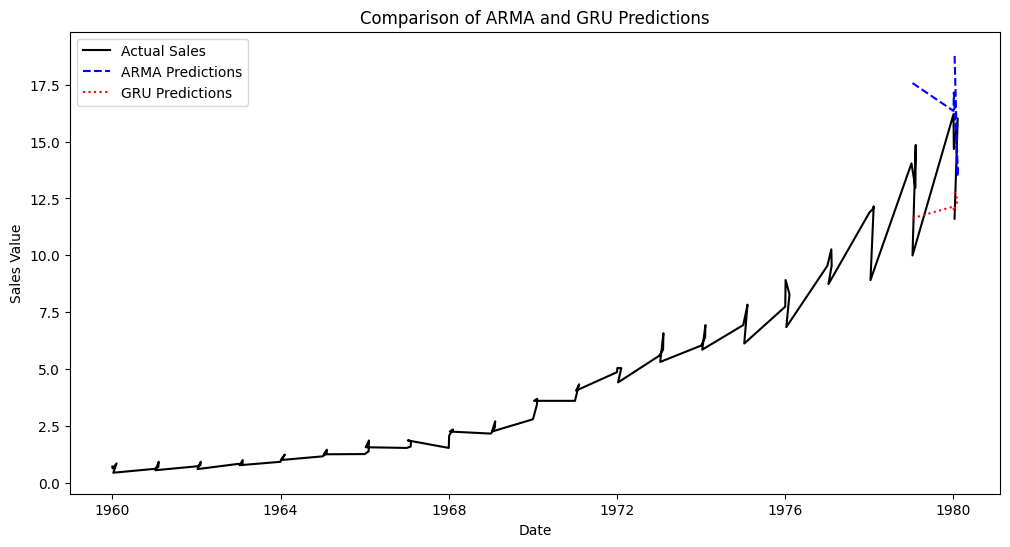

In [ ]:
# Plot the actual values, ARMA predictions, and GRU predictions
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(data['date'], data['sales_value'], label='Actual Sales', color='black')

# Plot ARMA model predictions (use the forecast from ARMA)
arma_forecast = arma_model_fit.forecast(steps=len(Y_test))  # ARMA forecast for the test set
plt.plot(data['date'][-len(Y_test):], arma_forecast, label='ARMA Predictions', color='blue', linestyle='--')

# Plot GRU model predictions
plt.plot(data['date'][-len(gru_predictions_rescaled):], gru_predictions_rescaled, label='GRU Predictions', color='red', linestyle=':')

plt.title('Comparison of ARMA and GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.show()
